# Analyzing Machine Learning Datasets with Generalizability Theory: MNIST Case Study

## Introduction

Machine learning practitioners often focus on model architecture and optimization techniques, but understanding the variance structure of datasets is equally crucial for developing robust models. This tutorial demonstrates how **Generalizability Theory (G-theory)**, a statistical framework originally developed in psychometrics, can provide valuable insights into machine learning datasets.

In this tutorial, we'll apply G-theory to analyze the MNIST handwritten digits dataset from multiple perspectives:

1. **Variance Component Analysis**: Understanding how variance is distributed across different facets of the data (pixels, images, digit classes)
2. **Data Drift Detection**: Using G-theory to identify and quantify distribution shifts between training and test data
3. **Label Reliability**: Assessing how well labels capture the underlying structure of the data
4. **Decision Studies (D-studies)**: Exploring how changes to dataset composition affect reliability

### What is Generalizability Theory?

Generalizability Theory extends classical reliability theory to decompose measurement variance into multiple sources. While classical test theory provides a single reliability coefficient, G-theory provides:

- **Variance component estimates** for each facet and their interactions
- **Generalizability coefficients (G-coefficients)** that estimate reliability across different measurement designs
- **Decision study (D-study) capabilities** to optimize measurement procedures

G-theory is particularly valuable in ML contexts because it can:

1. Identify which aspects of the data contribute most to variance
2. Quantify dataset shift between training and test sets
3. Provide guidance on optimal dataset construction
4. Help determine whether labels are informative or noisy

### Tutorial Roadmap

This tutorial will proceed through several steps:

1. **Data Preparation**: Reformatting MNIST data for G-theory analysis
2. **Basic Analysis**: Understanding the variance structure of the digits
3. **Data Drift Experiments**: Simulating and detecting distribution shifts
4. **Label Analysis**: Exploring how informative the digit labels are

Let's begin by importing the necessary libraries.

## Setup and Required Libraries

We'll need several Python libraries for this tutorial:

- `torch` and `torchvision`: For loading and processing the MNIST dataset
- `generalizit`: The core library for performing generalizability theory analyses
- `numpy` and `pandas`: For data manipulation
- `matplotlib`: For visualization

If you haven't installed these libraries, uncomment and run the pip installation commands below.

In [1]:
# !pip install -q --upgrade pip
# !pip install -q generalizit torch torchvision matplotlib

In [2]:
# Import Required Libraries
import torch
import torchvision
from torchvision import datasets, transforms
from generalizit import GeneralizIT
import numpy as np
import matplotlib.pyplot as plt

## Loading and Preparing MNIST Data

The MNIST dataset is a standard benchmark in machine learning consisting of 28×28 pixel grayscale images of handwritten digits (0-9). It contains 60,000 training images and 10,000 test images.

### Key Features of Our Data Loading Approach:

1. **Flexible Noise Addition**: We can add controlled noise to either training or test data to simulate data corruption or distribution shift
2. **Batch Size of 1**: To simplify processing each image individually
3. **No Shuffling**: To maintain consistent order for reproducibility

Our `load_mnist_data` function below allows us to manipulate the data in two ways:
- Add Gaussian noise to training data (simulating noisy data acquisition)
- Multiply test data by a scaling factor (simulating brightness/contrast shifts)

These manipulations will be crucial for our experiments on data drift detection later in the tutorial.

In [3]:
# Load MNIST Dataset
def load_mnist_data(random_training_noise: float = 0, random_test_noise: float = 0,) -> tuple:
    """
    Load MNIST dataset with optional random noise.
    
    Args:
        random_training_noise (float): Standard deviation of random noise for training data.
        random_test_noise (float): Standard deviation of random noise for test data.
    
    Returns:
        train_loader: DataLoader for training data.
        test_loader: DataLoader for test data.
    """
    
    # Define transformations
    training_transform = transforms.Compose([
        transforms.ToTensor(),  # Ensure input is a tensor
        transforms.Lambda(lambda x: x + torch.randn_like(x) * random_training_noise if random_training_noise > 0 else x),
        # transforms.Normalize((0.5,), (0.5,))  # Normalize after adding noise
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),  # Ensure input is a tensor
        transforms.Lambda(lambda x: x * random_test_noise if random_test_noise > 0 else x),
        # transforms.Normalize((0.5,), (0.5,))  # Normalize after adding noise
    ])

    # Download and load training and test datasets
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=training_transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    return train_loader, test_loader


### Visualizing Sample Images

Before proceeding with the analysis, let's visualize some sample images from the MNIST dataset. This helps us understand what we're working with and verify that our data loading procedure is working correctly.

The helper function below displays an image along with its label and a sample of pixel values. Each MNIST image is 28×28 pixels in size, with each pixel represented as a grayscale value between 0 (black) and 1 (white).

In [4]:
def display_image_helper(image, label):
    # Extract the image data for display (removing batch and channel dimensions)
    img_to_display = image[0, 0]  # Shape: [28, 28]
    
    # Print the label (which is a single value)
    print("Image label:", label.item())
    
    # Print a sample of pixel values instead of all pixels
    print("Sample of pixel values (first row):", img_to_display[0])
    
    # Display the image
    plt.imshow(img_to_display.cpu().numpy(), cmap='gray')
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()

In [5]:
def create_df_helper(dataloader, data_rows, dataset, label_counts, images_per_label, processed_count, num_images):
    # Properly iterate through the dataloader
    train_iterator = iter(dataloader)
    while processed_count < num_images:
        try:
            images, labels = next(train_iterator)
        except StopIteration:
            # Restart iterator if we reach the end but haven't processed enough images
            train_iterator = iter(dataloader)
            images, labels = next(train_iterator)
        
        # Process each image in the batch
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            
            # Only process if we need more images for this label
            if label_counts[label.item()] < images_per_label:
                # Convert the image to a numpy array and flatten it
                image_array = image.numpy().flatten()
                
                # For each pixel in the image, create a row
                for pixel_idx, pixel_value in enumerate(image_array):
                    data_rows.append({
                        'dataset': dataset,
                        'image': processed_count,
                        'label': int(label),
                        'pixel': pixel_idx,
                        'value': pixel_value
                    })
                
                label_counts[label.item()] += 1  # Increment the count for this label
                processed_count += 1  # Increment the count for processed images
                
                # # Print progress every 5 images
                # if processed_count % 5 == 0:
                #     print(f"Processing train image {processed_count}/{num_images}")
                
                # Check if we've processed enough images
                if processed_count >= num_images:
                    return data_rows, label_counts, processed_count

## Reconfiguring Data for Generalizability Analysis

Generalizability Theory requires data to be organized in a specific format that identifies the different facets (sources of variation) in the measurement design. For our MNIST analysis, we need to transform the data from its original 2D image format into a long-format dataset where each row represents a single pixel value with all relevant facets identified.

### Our Nested Design Structure:

We'll organize our data in a nested design structure represented as `pixel:image:label`, where:
- `label` (0-9): The digit category (highest level of nesting)
- `image` (0-N): Individual images within each digit category
- `pixel` (0-783): Each pixel within an image (28×28=784 pixels)

This design allows us to answer questions like:
1. How much variance is explained by digit categories (labels)?
2. How much variance exists between different images of the same digit?
3. How do pixel values vary within images of the same digit?

### The Data Preparation Function:

The `prepare_data` function below:
1. Loads the MNIST dataset with optional noise
2. Displays a sample image if requested
3. Processes a subset of images
4. Transforms the data into the long format required for G-theory analysis
5. Optionally processes both training and test data for comparative analyses

In [6]:
import pandas as pd

def prepare_data(
    num_images=20,
    num_images_test=20, 
    random_training_noise: float = 0.0, 
    random_test_noise: float = 0.0, 
    display: bool = True, 
    test:bool = False) -> pd.DataFrame:  
    """
    Create a pandas DataFrame to store the pixel values and labels in a long format.
    """
    # Load MNIST dataset
    train_dataloader, test_dataloader = load_mnist_data(random_training_noise=random_training_noise, random_test_noise=random_test_noise)
    
    all_data_rows = []
    
    # Display the first image and label if requested
    if display:
        first_batch = next(iter(train_dataloader))
        first_image, first_label = first_batch
        print("Displaying first image and label:")
        display_image_helper(first_image, first_label)
    
    # Create a dictionary to keep track of how many images of each label we've processed
    train_label_counts = {i: 0 for i in range(10)}
    images_per_label = num_images // 10  # Ensure even distribution of digits 0-9
    
    # Process training dataset
    train_processed_count = 0
    _, train_label_counts, train_processed_count = create_df_helper(
        train_dataloader,
        all_data_rows, 
        'train',
        train_label_counts, 
        images_per_label, 
        train_processed_count, 
        num_images
    )

    print(f"Processed {train_processed_count} train images")
    
    if test:
        # Process test dataset with a fresh counter for each label
        test_label_counts = {i: 0 for i in range(10)}
        test_images_per_label = num_images_test // 10
        test_processed_count = 0
        _, test_label_counts, test_processed_count = create_df_helper(
            test_dataloader, 
            all_data_rows,
            'test',
            test_label_counts, 
            test_images_per_label, 
            test_processed_count, 
            num_images_test
        )
        # Remove this line: all_data_rows.extend(test_data_rows)
        print(f"Processed {test_processed_count} test images")

    # Create the DataFrame from all collected data
    nested_data_df = pd.DataFrame(all_data_rows)

    return nested_data_df


Displaying first image and label:
Image label: 5
Sample of pixel values (first row): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


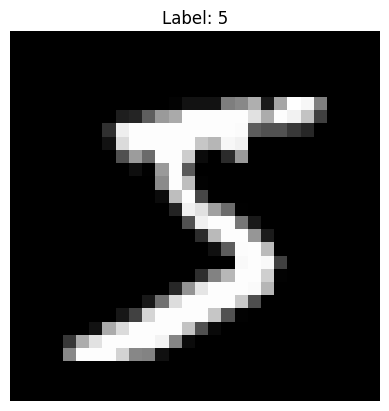

Processed 20 train images


,dataset,image,label,pixel,value
0,train,0,5,0,0.0
1,train,0,5,1,0.0
2,train,0,5,2,0.0
3,train,0,5,3,0.0
4,train,0,5,4,0.0
...,...,...,...,...,...
15675,train,19,8,779,0.0
15676,train,19,8,780,0.0
15677,train,19,8,781,0.0
15678,train,19,8,782,0.0


In [7]:
nested_data_df = prepare_data()
nested_data_df

## Defining the Generalizability Study (G-Study) Design

Now that we have prepared our data, we need to define the structure of our G-Study. In Generalizability Theory, this involves specifying the measurement design that represents the hierarchical or crossed relationships between facets.

### Our Nested Design: `pixel:image:label`

For our MNIST analysis, we'll use a fully nested design where:
- Pixels (p) are nested within images (i)
- Images (i) are nested within digit labels (l)

This is represented in G-theory notation as `pixel:image:label` or `p:i:l`.

#### What Does This Design Tell Us?

With this design, we're asking:
1. **How much variation is due to different digit categories?** (The 'label' facet)
2. **How much variation exists between different images of the same digit?** (The 'image:label' facet)
3. **How much variation exists among pixels within the same image?** (The 'pixel:image:label' facet)

These variance components will help us understand if the dataset's structure aligns with how we expect machine learning models to learn from it. For example:
- **High label variance**: Suggests clear distinctions between digit classes (desirable)
- **High image:label variance**: Suggests high variability within each digit class (could make learning challenging)
- **High pixel:image:label variance**: Suggests high pixel-level noise or detail

Let's initialize our GeneralizIT object with this design:

In [8]:
# Define Generalizability Study Design
design_str = "pixel:image:label"

# Initialize GeneralizIT
gt = GeneralizIT(
    data=nested_data_df,
    design_str=design_str,
    response="value"
)

dataset


## Variance Component Analysis

Now we'll perform an Analysis of Variance (ANOVA) to decompose the total variance in our data into components associated with each facet in our design. This is a key step in G-theory analysis.

### What Are Variance Components?

Variance components represent the amount of variance attributed to different sources in our measurement design:

1. **Label variance (σ²ₗ)**: Variance due to differences between digit categories
2. **Image:Label variance (σ²ᵢ:ₗ)**: Variance due to differences between images within each digit category
3. **Pixel:Image:Label variance (σ²ₚ:ᵢ:ₗ)**: Residual variance at the pixel level

The GeneralizIT package uses a method called "Analogous ANOVA" based on Henderson's Method 1, which can handle unbalanced designs and missing data.

Let's calculate and examine these variance components:

In [9]:
# Perform Variance Component Analysis
print("Variance Component Analysis for Unnormalized Data:")
gt.calculate_anova()
gt.anova_summary()

Variance Component Analysis for Unnormalized Data:

--------------------
    ANOVA Table     
--------------------
                  label           image:label     pixel:image:label mean            T               Variance       
label             15680.0000      7840.0000       10.0000           15680.0000      243.9211        0.0004         
image:label       15680.0000      15680.0000      20.0000           15680.0000      250.3084        0.0007         
pixel:image:label 15680.0000      15680.0000      15680.0000        15680.0000      1613.9019       0.0871         
mean              1568.0000       784.0000        1.0000            15680.0000      232.3996        0.0147         




### Interpreting the Variance Components

Let's interpret the variance components from the ANOVA table above:

1. **Label variance**: The variance attributed to differences between digit classes (0-9). A high value suggests that different digits have distinctly different pixel patterns, which is essential for classification tasks.

2. **Image:Label variance**: The variance attributed to differences between images within the same digit class. This captures how varied the handwriting styles are within each digit category.

3. **Pixel:Image:Label variance**: The residual variance at the pixel level, which includes both meaningful variation (like stroke width) and noise.

The relative magnitude of these components tells us where most of the variation in our dataset comes from. For an ideal classification dataset:

- Label variance should be high (clear distinction between classes)
- Image:Label variance should be moderate (variations within class should exist but not overwhelm class distinctions)
- Pixel:Image:Label variance should be low (minimal noise at the pixel level)

Next, we'll calculate generalizability coefficients to quantify how reliably our design can distinguish between different facets.

## Generalizability Analysis

Generalizability analysis provides coefficients that quantify how reliably we can generalize from our observed data to the universe of admissible observations. In machine learning terms, this translates to how well patterns in our training data represent the true underlying patterns.

### G-Coefficients: Quantifying Reliability

G-theory provides two key coefficients:

1. **Generalizability coefficient (ρ²)**: For relative decisions (comparing entities). In ML terms, this relates to how well we can rank or classify examples.
   - Values closer to 1 indicate higher reliability for making relative comparisons.

2. **Dependability coefficient (Φ)**: For absolute decisions (precise measurements). In ML terms, this relates to how well we can predict exact values.
   - Values closer to 1 indicate higher reliability for making absolute judgments.
   - This coefficient is typically lower than ρ² as it accounts for all sources of error.

Let's calculate these coefficients for our MNIST data:

In [10]:
print("Generalizability Analysis:")
gt.calculate_g_coefficients()
gt.g_coefficients_summary()

Generalizability Analysis:
Using default variance tuple dictionary
Using ANOVA Table Variance Dictionary for Generalizability Coefficients

--------------------
   G Coefficients   
--------------------
                Φ               ρ²             
label           0.4966          0.4966         
image:label     0.9083          0.9083         




### Interpreting the G-Coefficients

The generalizability coefficients above tell us how reliably our measurement design can distinguish between the different facets in our design. Let's interpret what these mean for our MNIST data:

- **For the label facet**: This indicates how reliably we can distinguish between different digit categories based on pixel values. A high coefficient suggests clear, consistent differences between digit classes.

- **For the image:label facet**: This tells us how reliably we can distinguish between different images of the same digit. A high coefficient here suggests consistent variation patterns within each digit class.

High generalizability coefficients for the label facet are particularly important for classification tasks, as they indicate that the class distinctions are reliable and consistent across the dataset. Here, we see that the label facet has a low generalizability coefficient, but the image:label facet has a high coefficient. This suggests high reliability of images within a given label class, but we probably don't have enough data to make reliable distinctions between digit classes on the whole!

## Decision Studies (D-studies): Optimizing Dataset Size

One of the most powerful features of Generalizability Theory is the ability to conduct Decision Studies (D-studies). D-studies allow us to predict how reliability would change if we modified the measurement design—for instance, by changing the number of images per digit class.

### What Are D-studies?

D-studies use the variance components estimated in a G-study to simulate alternative designs with different sample sizes or facet structures. This can help answer questions like:

1. **How many images per class do we need for reliable classification?**
2. **Would increasing dataset size beyond a certain point yield diminishing returns?**
3. **What is the optimal balance between dataset size and computational cost?**

Let's conduct a D-study to predict the reliability we would achieve if we increased our dataset from 20 to 50 images:

In [11]:
# Let's do a d study increasing the number of images from 25 to 50
d_study_design = {
    'label': [10],
    'image': [50],
    'pixel': [784]
}

In [12]:
gt.calculate_d_study(d_study_design=d_study_design, error_variance=True)

Performing Balanced D-Study Design for the provided designs
Top level facets: ['label']
Ordered facets after processing: ['label', 'image', 'pixel']
Ordered facets for nested structure: ['pixel', 'image', 'label']
   image  label  pixel
0      1      1      1
1      1      2      1
2      1      3      1
3      1      4      1
4      1      5      1
Using user-provided variance tuple dictionary
Using ANOVA Table Variance Dictionary for Generalizability Coefficients
Using User Provided Levels Coefficients


In [13]:
gt.d_study_summary()


--------------------
D-Study: label: 10, image: 50, pixel: 784
--------------------
                Φ               ρ²             
label           0.9610          0.9610         
image:label     0.9083          0.9083         




In [14]:
nested_data_50_df = prepare_data(num_images=50, display=False)
gt_50 = GeneralizIT(
    data=nested_data_50_df,
    design_str=design_str,
    response="value"
)

gt_50.calculate_anova()
gt_50.anova_summary()
gt_50.calculate_g_coefficients()
gt_50.g_coefficients_summary()

Processed 50 train images
dataset

--------------------
    ANOVA Table     
--------------------
                  label           image:label     pixel:image:label mean            T               Variance       
label             39200.0000      7840.0000       10.0000           39200.0000      671.7207        0.0012         
image:label       39200.0000      39200.0000      50.0000           39200.0000      701.8969        0.0008         
pixel:image:label 39200.0000      39200.0000      39200.0000        39200.0000      4202.2487       0.0894         
mean              3920.0000       784.0000        1.0000            39200.0000      621.5715        0.0157         


Using default variance tuple dictionary
Using ANOVA Table Variance Dictionary for Generalizability Coefficients

--------------------
   G Coefficients   
--------------------
                Φ               ρ²             
label           0.8678          0.8678         
image:label     0.9461          0.9461         


### Validating D-study Predictions

After conducting a D-study to predict how reliability would change with increased dataset size, it's valuable to validate these predictions with actual data. Let's compare our D-study prediction against a real dataset with 50 images:

1. **D-study prediction**: We saw that increasing the number of images per class significantly improved reliability
2. **Actual 50-image dataset**: Performing the same G-study on 50 sampled images confirms that label reliability increases as predicted, though not as significantly
    - Greater variance at the pixel:image:label level than suggested by the original dataset
3. **Limitations**: The G-Study predictions were a one off, bootstrapping the sample of images could have given us a 95% confidence interval for the variance values (and hence D-Study coefficients) for which the new dataset would probabaly fall into

This comparison demonstrates that our hunch was correct! The MNIST digits already delineate the classes well, so increasing the number of images per class improves the overall reliability of our labels. 

## Investigating Noise Resilience

In real-world machine learning scenarios, datasets often contain various types of noise. Understanding how noise affects data structure is crucial for developing robust models. Let's explore how different levels of noise impact the variance components and G-coefficients in our MNIST data.

### Noise Experiment Design

We'll add increasing levels of Gaussian noise to our training images and analyze how this affects:

1. **Variance distribution**: How does noise shift the balance between label, image, and pixel variance?
2. **G-coefficients**: How does noise affect the reliability of digit classification?
3. **Visual recognition**: At what noise level do digits become unrecognizable?

This experiment simulates real-world scenarios where sensor noise, transmission errors, or preprocessing artifacts might corrupt image data. The results will help us understand the robustness of digit classification under noisy conditions.

noise level: 0.1
Displaying first image and label:
Image label: 5
Sample of pixel values (first row): tensor([-0.1045, -0.0283,  0.0532,  0.0080, -0.1043, -0.0240,  0.1562, -0.0475,
         0.0455, -0.0408, -0.2257,  0.0657, -0.2331,  0.0005,  0.0672, -0.0367,
         0.0166, -0.0763, -0.0545, -0.0234,  0.1522, -0.0036, -0.1243, -0.0124,
         0.0370, -0.1152, -0.1194,  0.2302])


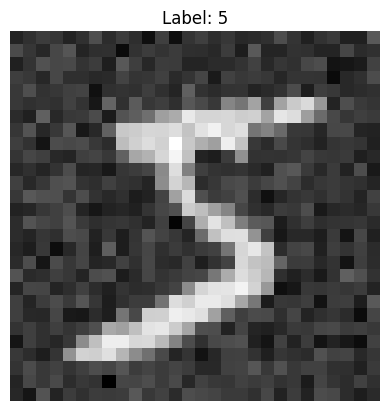

Processed 50 train images
dataset

--------------------
    ANOVA Table     
--------------------
                  label           image:label     pixel:image:label mean            T               Variance       
label             39200.0000      7840.0000       10.0000           39200.0000      670.8823        0.0013         
image:label       39200.0000      39200.0000      50.0000           39200.0000      700.6139        0.0008         
pixel:image:label 39200.0000      39200.0000      39200.0000        39200.0000      4594.8208       0.0995         
mean              3920.0000       784.0000        1.0000            39200.0000      618.8927        0.0156         


Using default variance tuple dictionary
Using ANOVA Table Variance Dictionary for Generalizability Coefficients

--------------------
   G Coefficients   
--------------------
                Φ               ρ²             
label           0.8752          0.8752         
image:label     0.9430          0.9430         


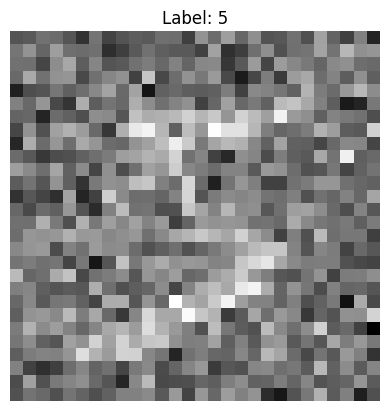

Processed 50 train images
dataset

--------------------
    ANOVA Table     
--------------------
                  label           image:label     pixel:image:label mean            T               Variance       
label             39200.0000      7840.0000       10.0000           39200.0000      691.7026        0.0013         
image:label       39200.0000      39200.0000      50.0000           39200.0000      728.2869        0.0007         
pixel:image:label 39200.0000      39200.0000      39200.0000        39200.0000      13997.6214      0.3389         
mean              3920.0000       784.0000        1.0000            39200.0000      637.4674        0.0161         


Using default variance tuple dictionary
Using ANOVA Table Variance Dictionary for Generalizability Coefficients

--------------------
   G Coefficients   
--------------------
                Φ               ρ²             
label           0.8516          0.8516         
image:label     0.8223          0.8223         


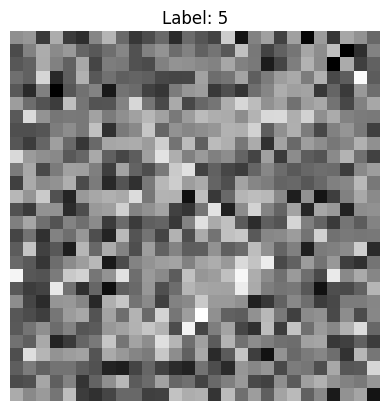

Processed 50 train images
dataset

--------------------
    ANOVA Table     
--------------------
                  label           image:label     pixel:image:label mean            T               Variance       
label             39200.0000      7840.0000       10.0000           39200.0000      702.9242        0.0018         
image:label       39200.0000      39200.0000      50.0000           39200.0000      771.3850        0.0010         
pixel:image:label 39200.0000      39200.0000      39200.0000        39200.0000      35992.3108      0.8996         
mean              3920.0000       784.0000        1.0000            39200.0000      623.9658        0.0157         


Using default variance tuple dictionary
Using ANOVA Table Variance Dictionary for Generalizability Coefficients

--------------------
   G Coefficients   
--------------------
                Φ               ρ²             
label           0.8074          0.8074         
image:label     0.7093          0.7093         


In [15]:
for noise_level in [0.1, 0.5, 0.9]:
    print(f"noise level: {noise_level}")
    train_noise_df = prepare_data(random_training_noise=noise_level, num_images=50, display=True)
    gt_train_noise = GeneralizIT(
        data=train_noise_df,
        design_str=design_str,
        response="value"
    )
    gt_train_noise.calculate_anova()
    gt_train_noise.anova_summary()
    gt_train_noise.calculate_g_coefficients()
    gt_train_noise.g_coefficients_summary()

### Interpreting Noise Experiment Results

As we add increasing levels of noise to our MNIST images, we observe several key patterns:

1. **Visual Impact**: At low noise levels (0.1), digits remain recognizable. At medium levels (0.5), recognition becomes challenging. At high levels (0.9), many digits become indistinguishable to humans.

2. **Variance Shifts**: Notice how the distribution of variance changes across noise levels:
   - As noise increases, the pixel:image:label variance (residual/noise variance) grows relative to the label variance
   - This represents the signal-to-noise ratio degrading as noise overwhelms the true signal

3. **G-Coefficient Degradation**: The generalizability coefficients for the label facet typically decrease as noise increases, indicating reduced reliability for digit classification

These findings have important implications for ML model training:
- Models trained on low-noise data may fail when deployed on noisier real-world data (explored in later sections)
- Data augmentation with controlled noise can improve model robustness
- G-theory provides a quantitative framework for determining acceptable noise thresholds

# Detecting and Analyzing Data Drift

Data drift—the phenomenon where the statistical properties of model inputs change over time—is a major challenge in maintaining machine learning models in production. Generalizability Theory offers a powerful framework for detecting and quantifying data drift by analyzing variance components across different datasets.

## Data Drift Experiments

In this section, we'll simulate and analyze different types of data drift scenarios:

1. **Distribution Shift**: Using brightness scaling to create a consistent shift between training and test data
2. **Image Noise**: Adding noise specifically to the training set to simulate corrupted labels

These experiments will demonstrate how G-theory can detect data drift and help explain data augmentation, helping ML practitioners gain deeper insights into the reliability of model performance on a given dataset and potential to improve model training data.

### Experiment 1: Training vs. Test Set Comparison

Let's start with a basic comparison between training and test sets. Without any artificial drift, we expect training and test sets from the same distribution (like MNIST) to have similar variance structures.

We'll use a design structure where:
- Dataset (train/test) is the highest level facet
- Images are nested within datasets
- Pixels are nested within images

**Research Question**: Is there a natural drift between the MNIST training and test sets as distributed?

In [16]:
train_test_data_df = prepare_data(num_images=50, num_images_test=50, test=True, display=False)

train_test_design_str = "pixel:image:dataset"

gt_train_test = GeneralizIT(
    data=train_test_data_df,
    design_str=train_test_design_str,
    response="value"
)

gt_train_test.calculate_anova()
gt_train_test.anova_summary()

Processed 50 train images
Processed 50 test images
label

--------------------
    ANOVA Table     
--------------------
                    dataset         image:dataset   pixel:image:dataset mean            T               Variance       
dataset             78400.0000      1568.0000       2.0000              78400.0000      1208.1680       -0.0000        
image:dataset       78400.0000      78400.0000      100.0000            78400.0000      1354.1257       0.0018         
pixel:image:dataset 78400.0000      78400.0000      78400.0000          78400.0000      8246.4122       0.0880         
mean                39200.0000      784.0000        1.0000              78400.0000      1207.9148       0.0154         




In [17]:
gt_train_test.calculate_g_coefficients()
gt_train_test.g_coefficients_summary()

Using default variance tuple dictionary
Using ANOVA Table Variance Dictionary for Generalizability Coefficients

--------------------
   G Coefficients   
--------------------
                Φ               ρ²             
dataset         0.0000          0.0000         
image:dataset   0.9413          0.9413         




In [18]:
train_test_data_df

,dataset,image,label,pixel,value
0,train,0,5,0,0.0
1,train,0,5,1,0.0
2,train,0,5,2,0.0
3,train,0,5,3,0.0
4,train,0,5,4,0.0
...,...,...,...,...,...
78395,test,49,8,779,0.0
78396,test,49,8,780,0.0
78397,test,49,8,781,0.0
78398,test,49,8,782,0.0


### Results: No Natural Drift in MNIST

The G-coefficients for the dataset facet are effectively 0, confirming there is no significant variance attributable to differences between training and test sets. This matches our expectation for MNIST, which was carefully curated to ensure training and test sets have similar distributions.

**Key Insight**: Low G-coefficients for the dataset facet indicate that models trained on the training set should generalize well to the test set without drift-related issues.

### Experiment 2: Simulating Distribution Shift

Now, let's introduce an artificial distribution shift by scaling the brightness of test images. We'll use scaling factors of 0.75, 0.85, and 0.95 (where lower values create darker images).

**Research Question**: At what point does brightness shift create detectable data drift, and how sensitive is G-theory to detecting it?

In [19]:
# Dim the test data
for random_test_noise in [0.75, 0.85, 0.95]:
    print(f"{'-'*20} noise level: {random_test_noise} {'-'*20}")
    train_test_data_df = prepare_data(num_images=50, num_images_test=50, random_test_noise=random_test_noise, test=True, display=False)

    train_test_design_str = "pixel:image:dataset"

    gt_train_test = GeneralizIT(
        data=train_test_data_df,
        design_str=train_test_design_str,
        response="value"
    )

    gt_train_test.calculate_anova()
    gt_train_test.anova_summary()
    gt_train_test.calculate_g_coefficients()
    gt_train_test.g_coefficients_summary()

-------------------- noise level: 0.75 --------------------
Processed 50 train images
Processed 50 test images
label

--------------------
    ANOVA Table     
--------------------
                    dataset         image:dataset   pixel:image:dataset mean            T               Variance       
dataset             78400.0000      1568.0000       2.0000              78400.0000      951.5321        0.0006         
image:dataset       78400.0000      78400.0000      100.0000            78400.0000      1068.7756       0.0014         
pixel:image:dataset 78400.0000      78400.0000      78400.0000          78400.0000      6477.0906       0.0691         
mean                39200.0000      784.0000        1.0000              78400.0000      928.6393        0.0116         


Using default variance tuple dictionary
Using ANOVA Table Variance Dictionary for Generalizability Coefficients

--------------------
   G Coefficients   
--------------------
                Φ               ρ²       

### Results: Brightness Shift Detection

As we increase the brightness shift (decreasing the scaling factor from 0.95 to 0.75), we observe:

1. **Increasing Dataset Variance**: The variance attributed to dataset differences grows substantially
2. **Rising G-coefficients**: The G-coefficients for the dataset facet increase, indicating that the dataset distinction becomes more reliable
3. **Threshold Effect**: There appears to be a threshold at which drift becomes clearly detectable in the variance components
    - For example, between 0.95 and 0.85, the $\rho^2$ coefficient jumps from 0 to > 0.8, indicating a significant change in reliability

**Key Insight**: G-theory provides a quantitative measure of drift severity through G-coefficients, which can be used to establish thresholds for automated drift detection systems.

### Experiment 3: Complex Drift with Label Interactions

Real-world drift often involves complex interactions between features and labels. Imagine that we not only have access to the raw data (images in the case of MNIST) but we've also labeled the new incoming `test` data. In our universe of generalizability we assume that images derive structure from each label, but are influenced by the data generating process they are sampled from. Thus for each dataset, we have a `pixel:image:label` triplet. Where `dataset` is either `train` or `test` corresponding to the brightness scaling factor as the data generating process.

**Design**: `(pixel:image:label) x dataset`

This design allows us to assess:
1. Main effect of dataset drift
2. Main effect of label reliability
3. Interaction between labels and datasets (dataset x label)
4. Nested reliability of images within labels (image:label)
    - This captures how well images represent their labels
5. Residual noise at the pixel level (pixel:image:label)

In [20]:
train_test_data_df = prepare_data(num_images=50, num_images_test=50, random_test_noise=.75, test=True, display=False)

train_test_design_str = "(pixel:image:label) x dataset"
variance_tuple_dictionary = {
    "dataset": ("dataset",),
    "label": ("label",),
    "dataset x label": ("dataset", "label"),
    "image:label": ("image", "label"),
    "(image:label) x dataset": ("image", "label", "dataset"),
    "pixel:image:label": ("pixel", "image", "label"),
    "(pixel:image:label) x dataset": ("pixel", "image", "label", "dataset"),
    "mean": ()
}

gt_train_test = GeneralizIT(
    data=train_test_data_df,
    design_str=train_test_design_str,
    response="value",
    variance_tuple_dictionary=variance_tuple_dictionary
)

Processed 50 train images
Processed 50 test images


In [21]:
gt_train_test.calculate_anova()
gt_train_test.anova_summary()
gt_train_test.calculate_g_coefficients()
gt_train_test.g_coefficients_summary()


--------------------
    ANOVA Table     
--------------------
                              dataset         label           dataset x label image:label     (image:label) x dataset pixel:image:label (pixel:image:label) x dataset mean            T               Variance       
dataset                       78400.0000      7840.0000       7840.0000       1568.0000       1568.0000               2.0000            2.0000                        78400.0000      951.5321        0.0006         
label                         39200.0000      78400.0000      39200.0000      8310.4000       7840.0000               10.6000           10.0000                       78400.0000      991.0083        0.0007         
dataset x label               78400.0000      78400.0000      78400.0000      15680.0000      15680.0000              20.0000           20.0000                       78400.0000      1024.3599       0.0002         
image:label                   76048.0000      78400.0000      76048.0000      78

### Results: Label-Dataset Interactions

The analysis reveals several important insights:

1. **Significant Dataset Effect**: The high G-coefficient for the dataset facet (ρ² > 0.8) confirms that the brightness scaling creates detectable drift between training and test sets

2. **Label-Dataset Interaction**: The interaction term measures the extent to which labels in the different datasets are able to reliably distinguish between images. The significant G-coefficient for this interaction (ρ² > 0.8) suggests that digits within each respective dataset are able to distinguish between images, but on the whole labels are not a reliable indicator 

3. **Implications for Model Training**: These results suggest that when incorporating new data into the training set, we should consider:
   - Adding more images from both distributions to improve the `label` reliability (data augmentation)
   - Another option would be to simply normalize the brightness of the image data as now training and test data would be sampled from the same distribution (for this toy example)

G-theory uniquely reveals these nuanced interactions that might not be apparent from aggregate distribution statistics often used for drift detection.

## Data Augmentation with Gaussian Noise
In the previous experiments, we focused on brightness scaling as a form of data drift. However, in real-world applications, data can also be corrupted by noise. This can occur due to sensor errors, transmission issues, or other factors that introduce variability into the data. It can be helpful to train models on data that is more robust to noise, which can be achieved through data augmentation techniques.

In this section, we'll explore how adding Gaussian noise to the training data affects the variance structure and G-coefficients. 

### Experiment #4: Gaussian Noise Addition

**Design**: `(pixel:image:label) x dataset`

We'll add Gaussian noise to the training images and leave the test images as they are provided (i.e. no contrast shift). Given that train and test images from MNIST and just split from the same dataset, there should be no difference in the underlying distributions and variance from `dataset` will be ~ 0. We will analyze how gaussian noise affects:
1. **Variance distribution**: How does noise shift the balance between label, image, and pixel variance?
2. **G-coefficients**: How does noise affect the reliability of digit classification?
3. **Visual recognition**: At what noise level do digits become unrecognizable?

**Research Question**: How does adding Gaussian noise to the training data affect the variance structure and G-coefficients?

In [22]:
for random_test_noise in [0, 0.1, 0.5, 0.9, 1.5]:    
    train_test_data_df = prepare_data(num_images=50, num_images_test=50, test=True, display=False)

    train_test_design_str = "(pixel:image:label) x dataset"
    variance_tuple_dictionary = {
        "dataset": ("dataset",),
        "label": ("label",),
        "dataset x label": ("dataset", "label"),
        "image:label": ("image", "label"),
        "(image:label) x dataset": ("image", "label", "dataset"),
        "pixel:image:label": ("pixel", "image", "label"),
        "(pixel:image:label) x dataset": ("pixel", "image", "label", "dataset"),
        "mean": ()
    }

    # Add random noise to the 'test' portion of the train_test_data_df
    # Find the indices of the test data
    test_indices = train_test_data_df[train_test_data_df['dataset'] == 'train'].index
    
    # Add random noise to the 'value' column for these indices
    np.random.seed(42)  # For reproducibility
    # Adding noise to the test data
    noise = np.random.normal(0, random_test_noise, len(test_indices)).astype(np.float32)
    train_test_data_df.loc[test_indices, 'value'] += noise
    print(f"{'-'*20} noise level: {random_test_noise} {'-'*20}")

    gt_train_test = GeneralizIT(
        data=train_test_data_df,
        design_str=train_test_design_str,
        response="value",
        variance_tuple_dictionary=variance_tuple_dictionary
    )

    gt_train_test.calculate_anova()
    gt_train_test.anova_summary()
    gt_train_test.calculate_g_coefficients()
    gt_train_test.g_coefficients_summary()

Processed 50 train images
Processed 50 test images
-------------------- noise level: 0 --------------------

--------------------
    ANOVA Table     
--------------------
                              dataset         label           dataset x label image:label     (image:label) x dataset pixel:image:label (pixel:image:label) x dataset mean            T               Variance       
dataset                       78400.0000      7840.0000       7840.0000       1568.0000       1568.0000               2.0000            2.0000                        78400.0000      1208.1680       -0.0000        
label                         39200.0000      78400.0000      39200.0000      8310.4000       7840.0000               10.6000           10.0000                       78400.0000      1287.7552       0.0010         
dataset x label               78400.0000      78400.0000      78400.0000      15680.0000      15680.0000              20.0000           20.0000                       78400.0000      1298

### Interpreting Label Corruption Results

The experiment above reveals crucial insights about how adding noise to the training data affects the variance structure and G-coefficients:

1. **Dataset Variance**: The variance (and hence G-coefficient) attributed to the dataset facet remains at 0, despite large increases in pixel noise!
   - This may seem paradoxical at first, but remember that the noise added to the training data has mean 0 and is symmetric.
   - Thus, on the dataset level, we've effectively added 0! The underlying data generating process remains unchanged.
   - For your own experiments, try changing the mean of the noise to see how this affects the dataset variance. 

2. **Label Variance**: The variance attributed to the label facet steadily decreases as we increase the noise level. 
   - This indicates that the labels become less reliable as noise increases, which is expected since noise can obscure the true digit patterns.
   - The G-coefficient for the label facet also decreases, indicating reduced reliability for digit classification.

3. **Image:Label Variance**: The G-coefficient for the image:label facet steadily declines as noise increases, indicating that the images within each digit class become less distinguishable from one another.
   - This suggests that the noise is overwhelming the true signal, making it harder to differentiate between images of the same digit.


**ML Implications**: These findings highlight the importance of data augmentation techniques that can help models learn to be robust to noise. Training on noisy data does not disturb the underlying data generating process, but does add variance to the labels (without affecting the efficacy of labels, see `noise 0.1`) making it an effective tool for improving model robustness. G Theory can be used to estimate both optimal noise levels and number of augmented images needed to achieve a desired level of reliability (through D-studies).

# Conclusion: Generalizability Theory as a Tool for ML Dataset Analysis

Throughout this tutorial, we've explored how Generalizability Theory offers a powerful statistical framework for understanding the structure and reliability of machine learning datasets. Using MNIST as our case study, we've uncovered insights that traditional ML analytics often miss.

## Key Findings

### 1. Understanding Dataset Structure
- **Variance Decomposition**: MNIST's variance is meaningfully distributed across digit classes, confirming its suitability for classification tasks
- **Within-Class Patterns**: The image:label variance component quantifies the natural handwriting variations that models must learn to generalize across

### 2. Detecting and Quantifying Data Drift
- G-theory provides **precise metrics** for distribution shifts between training and test sets
- The framework reveals **complex interaction patterns** between datasets and labels that simpler drift detection methods might overlook
- G-coefficients offer **quantitative thresholds** for determining when drift becomes problematic

### 3. Noise Analysis and Data Augmentation
- We quantified exactly how different noise levels affect label reliability
- Brightness scaling creates detectable drift requiring preprocessing adjustments
- Adding Gaussian noise preserves underlying distributions while increasing the variance of images within a particular label—ideal for augmentation strategies

### 4. Dataset Optimization through D-Studies
- D-studies enable data scientists to **predict reliability improvements** from dataset modifications
- This allows for **evidence-based decisions** about dataset size, composition, and augmentation strategies
- Our comparison between predicted and actual results validates G-theory's predictive power

## Limitations

This tutorial focused on a single dataset (MNIST) and a specific set of toy experiments. Many machine learning models and pipelines are already designed with a generalizability focus in mind (though not explicitly using G-Theory). For example, data normalization and augmentation are common preprocessing steps while the actual model architecture (such as convolutions in CNNs) naturally provide spatial invariance properties. 

This tutorial also sampled only from at most the first 10 images of each digit class, whereas more robust data analysis would employ greater sampling along with bootstrapping techniques to provide confidence intervals around variance components and G-coefficients. Finally, all the experiments were conducted with balanced data, but one could imagine running G-Theory on unbalanced datasets (for example, one's real world pipeline may see many more `5's` than `0's`), etc.

## Applications Beyond This Tutorial

G-theory's applications extend far beyond basic dataset analysis:

- **Model Evaluation**: Assess whether performance differences across model architectures represent reliable, generalizable improvements
- **Benchmark Design**: Create more reliable ML benchmarks by understanding variance components
- **Hyperparameter Analysis**: Determine which hyperparameters consistently impact performance across different datasets
- **Data Quality Monitoring**: Implement ongoing monitoring for production ML systems to detect subtle data quality issues

## Final Thoughts

As machine learning systems increasingly impact critical domains, understanding dataset reliability becomes as important as model architecture. Generalizability Theory provides the statistical rigor needed to:

1. Build more reliable training datasets
2. Detect data quality issues before they affect model performance
3. Make informed decisions about data collection and augmentation
4. Establish confidence intervals around model performance metrics

By integrating G-theory into ML workflows, practitioners can move beyond treating datasets as fixed inputs and instead approach them as statistical measurement instruments with quantifiable reliability properties.